In [1]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import xarray as xr
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
import os
import time
from IPython.display import clear_output
import pyproj

In [2]:
# some_file.py
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/glade/u/home/rossamower/work/scripts/snowmodel')
import intersect

In [3]:
year = 2018
sm_output_dir = f'/glade/derecho/scratch/rossamower/snow/snowmodel/school/uw/osse/domains/sierras/tuolumne_melt/outputs/wo_assim/wy_{year}/'
model = 'np_50_2'
wrf_prohj_string = '+proj=lcc +lat_1=30.0 +lat_2=50.0 +lat_0=39.100006 +lon_0=-97.9 +a=6370000 +b=6370000 +type=crs'

In [4]:
def reproject_clip(da,wrf_prohj_string,sentinel_da,resamp = 'nearest'):
    
    p = pyproj.Proj(wrf_prohj_string)
    try:
        XLAT = da.xlat.values
        XLON = da.xlon.values
    except:
        XLAT = da.XLAT.values
        XLON = da.XLONG.values

    proj_x,proj_y = p(XLON,XLAT,inverse = False)

    ## convert 2D lat/lon to 1D for rio reprojection and clipping ##
    lon_2v = proj_x[int(XLAT.shape[0]/2),:]
    lat_2v = proj_y[:,int(XLAT.shape[1]/2)]
    
    if len(da.shape) == 3:
        da = xr.DataArray(
                      data = da.squeeze().values,
                      dims = ["y","x"],
                      coords = dict(
                        y = (["y"], lat_2v),
                        x = (["x"], lon_2v)
                      )
                    )
    else:
        da = xr.DataArray(
                      data = da.values,
                      dims = ["y","x"],
                      coords = dict(
                        y = (["y"], lat_2v),
                        x = (["x"], lon_2v)
                      )
                    )
    ### write projection ##
    da = da.rio.write_crs(wrf_prohj_string, inplace=True)

    # da_reproj = da.rio.reproject('EPSG:4326')
    return da

In [5]:
def find_file_index(date,time_):
    return np.abs(date - time_).argmin()

## load shape

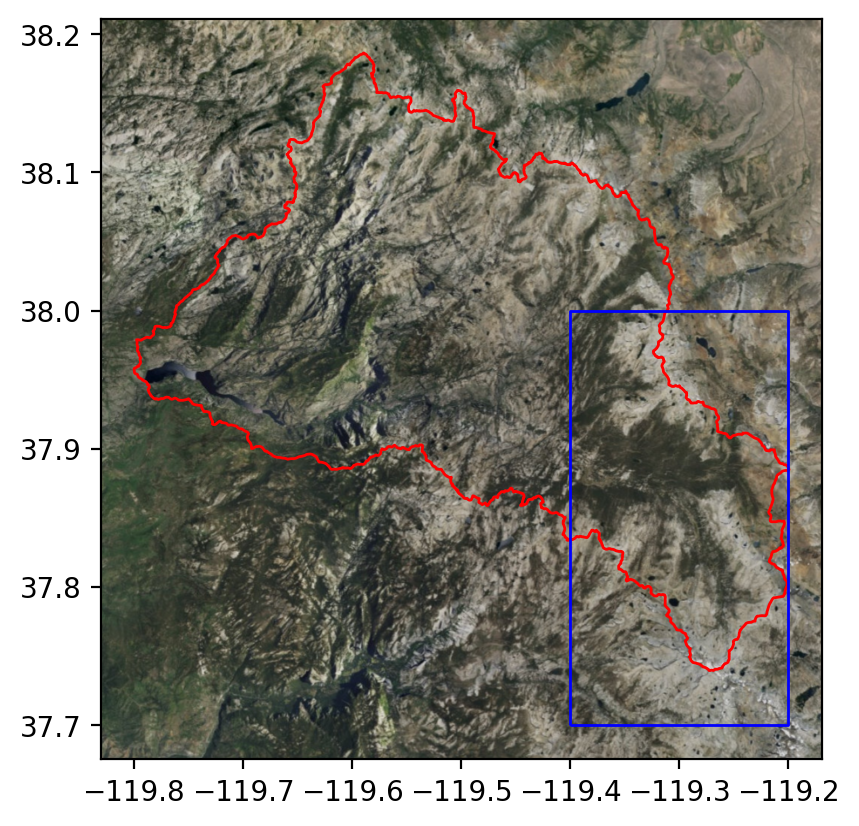

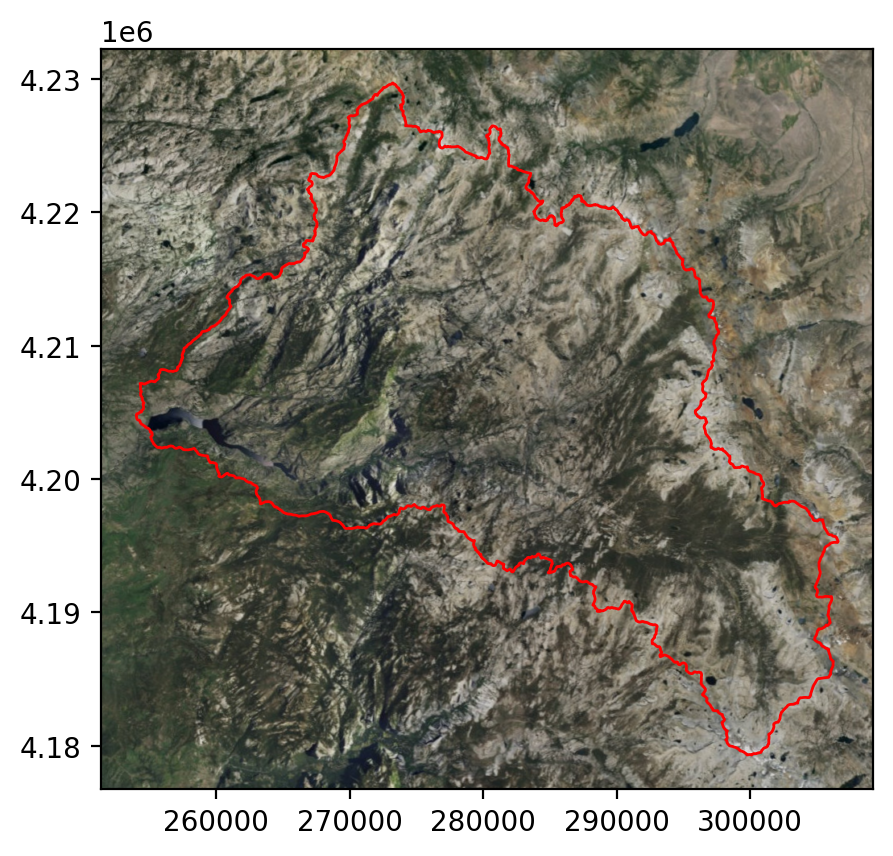

In [6]:
# load tuolumne shape
tu_gdf = gpd.read_file('~/work/aso_project/snotel_aso_predictability/data/shape/USCATM/USCATM.shp')
tu_gdf_proj = tu_gdf.to_crs('epsg:32611')

# create tuolumne subdomain
xmin_,xmax_ = -119.4,-119.2
ymin_,ymax_ = 37.7,38

coords = [(xmin_, ymin_),
          (xmin_, ymax_),
          (xmax_, ymax_),
          (xmax_, ymin_),
          (xmin_, ymin_)]

polygon = Polygon(coords)

subset_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])
subset_gdf_proj = subset_gdf.to_crs('epsg:32611')

# plot shapes.
fig,ax = plt.subplots(dpi=200)
tu_gdf.plot(ax=ax,color = 'none',edgecolor = 'red')
subset_gdf.plot(ax=ax,color = 'none',edgecolor='blue')
ctx.add_basemap(ax=ax, crs='EPSG:4326', source=ctx.providers.USGS.USImagery, attribution=False)


fig,ax = plt.subplots(dpi=200)
tu_gdf_proj.plot(ax=ax,color = 'none',edgecolor = 'red')
# subset_gdf.plot(ax=ax,color = 'none',edgecolor='blue')
ctx.add_basemap(ax=ax, crs='epsg:32611', source=ctx.providers.USGS.USImagery, attribution=False)


In [7]:
# get list of snowmodel files.
def get_output_files(sm_output_dir,model,var):
    sm_output_fpath = f'{sm_output_dir}{model}/netcdf/'
    if 'multilayer' not in var:
        output_list = sorted([sm_output_fpath + i for i in os.listdir(sm_output_fpath) if var in i and 'multilayer' not in i])
    else:
        output_list = sorted([sm_output_fpath + i for i in os.listdir(sm_output_fpath) if var in i and 'multilayer' in i])

    # get dates of corresponding files.
    date = [i.split('_')[-1] for i in output_list]
    date = [i.replace('.nc','') for i in date]
    date = np.array([np.datetime64(f'{i[0:4]}-{i[4:6]}-{i[6:8]}T{i[8:10]}:00:00') for i in date])
    return output_list,date

In [8]:
def prepare_violin_df(ds,coarsen = 10):
    df_aso = ds.aso.coarsen({'x':coarsen,'y':coarsen},boundary = 'pad').mean().to_dataframe().reset_index()
    df_sm = ds.snowmodel.coarsen({'x':coarsen,'y':coarsen},boundary = 'pad').mean().to_dataframe().reset_index()
    df_sm.rename(columns = {'snowmodel':'swe'},inplace = True)
    df_aso.rename(columns = {'aso':'swe'},inplace = True)
    df_sm['dataset'] = 'snowmodel'
    df_aso['dataset'] = 'aso'
    df_swe = pd.concat([df_aso,df_sm]).reset_index(drop = True)
    return df_swe

In [9]:
def dswe_dz(distributed_swe,labels_sm,bins_sm,swe_var = 'snowmodel'):
    """
        Group by elevation bin and aggregate mean swe for dswe/dz calculations.
        INPUT:
            distributed_swe: xarray distributed swe dataset (contains both aso and snowmodel variables).
            labels_sm: numpy array of bin labels.
            bins_sm: numpy array of bin values.
            swe_var: variable to reference in xarray dataset.
        OUTPUT:
            vals_sm_lst: aggregated list of SWE at elevation bin.
            
    """
    # instantiate empty list.
    vals_sm_lst = []
    elevs_sm_lst = []

    # loop through elevation bins.
    for i in range(0,len(labels_sm)):
        print(i,end = ' ')
        # group by and average swe value based on elevation bin.
        try:
            val = float(distributed_swe.squeeze('time').groupby_bins('hgt',bins_sm,labels = labels_sm)[labels_sm[i]][swe_var].mean().values) ## snowmodel elevation bins
        except:
            val = np.nan
        elev = (bins_sm[i] + bins_sm[i+1]) / 2 ## snowmodel bins
        vals_sm_lst.append(val)
        elevs_sm_lst.append(elev)

    if swe_var == 'snowmodel':
        return vals_sm_lst,elevs_sm_lst
    else:
        return vals_sm_lst

def prepare_dswe_dz(ds,num_bins = 25):
    """
    Group by elevation bin and aggregate mean swe for dswe/dz calculations.
    INPUT:
        ds: xarray distributed swe dataset (contains aso, snowmodel, and elevation distributed variables).
        num_bins: number of bins over elevation distribution.
        bins_sm: numpy array of bin values.
        swe_var: variable to reference in xarray dataset.
    OUTPUT:
        vals_sm_lst: aggregated list of SWE at elevation bin.
            
    """
    # pull out elevation to 2d numpy array.
    hgt_vals_sm = ds['hgt'].values
    # remove nans.
    hgt_vals_sm = hgt_vals_sm[~np.isnan(hgt_vals_sm)]
    # bin data and create count and labels.
    count_sm,bins_sm = np.histogram(hgt_vals_sm,bins = num_bins)
    labels_sm = np.arange(0,num_bins)
    # aggregate over binned data for snowmodel.
    vals_sm,elev = dswe_dz(ds,labels_sm,bins_sm,swe_var = 'snowmodel')
    # aggregate over binned data for aso.
    vals_aso = dswe_dz(ds,labels_sm,bins_sm,swe_var = 'aso')
    # combine aggregated information into dataframe.
    df_dswe_dz = pd.DataFrame(data = {'elev':elev,
                                      'time':[str(ds.time.values[0])[0:10]]*len(vals_sm),
                                      'mean_swe_sm':vals_sm,
                                      'mean_swe_aso':vals_aso}
            )
    return df_dswe_dz
    

2017-03-03


/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/derecho/scratch/rossamower/tmp/ipykernel_13707/2719682709.py:67: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
2017-04-01


/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/derecho/scratch/rossamower/tmp/ipykernel_13707/2719682709.py:67: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
2017-05-02


/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/derecho/scratch/rossamower/tmp/ipykernel_13707/2719682709.py:67: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
2017-06-04


/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/derecho/scratch/rossamower/tmp/ipykernel_13707/2719682709.py:67: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
2017-07-17


/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/derecho/scratch/rossamower/tmp/ipykernel_13707/2719682709.py:67: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
2017-07-27


/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/derecho/scratch/rossamower/tmp/ipykernel_13707/2719682709.py:67: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
2017-08-16


/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/derecho/scratch/rossamower/tmp/ipykernel_13707/2719682709.py:67: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
2018-04-23


/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/derecho/scratch/rossamower/tmp/ipykernel_13707/2719682709.py:67: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
2018-05-28


/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/derecho/scratch/rossamower/tmp/ipykernel_13707/2719682709.py:67: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
2017-01-29


/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/work/rossamower/conda-envs/proj_2024/lib/python3.9/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/glade/derecho/scratch/rossamower/tmp/ipykernel_13707/2719682709.py:67: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 


<Axes: xlabel='time', ylabel='swe'>

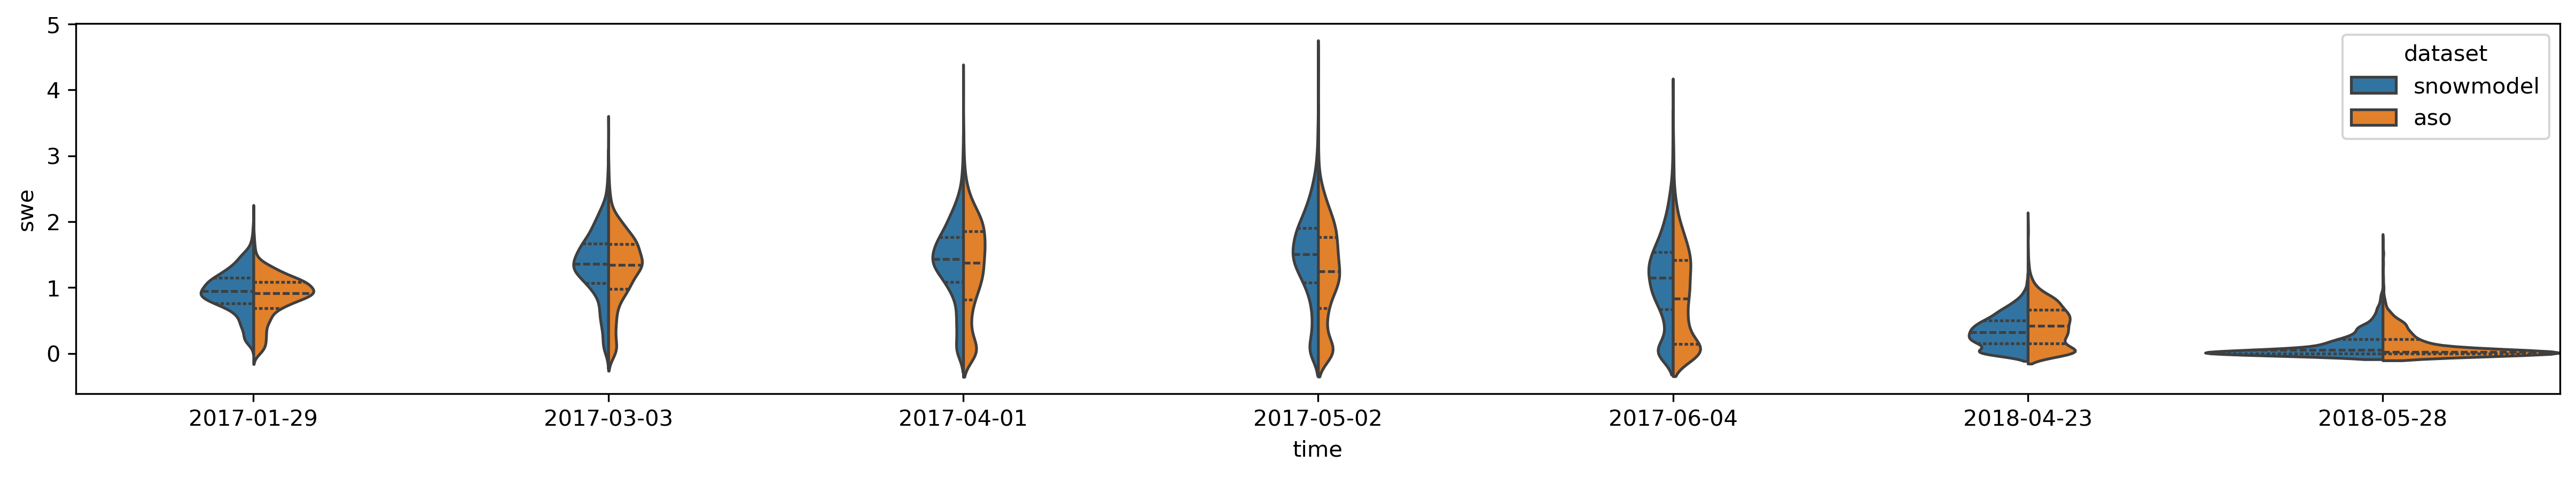

In [10]:
import rioxarray as rxr
import copy
import seaborn as sns
aso_dir = '../data/aso/'

year = 2017
sm_output_dir = f'/glade/derecho/scratch/rossamower/snow/snowmodel/school/uw/osse/domains/sierras/tuolumne_melt/outputs/wo_assim/wy_{year}/'
model = 'np_50_2'
var = 'swed'

# load snowmodel geography
sm_geog = xr.load_dataset(f'{sm_output_dir}{model}/geography/ctrl_geog.nc')
# elevation
hgt = sm_geog.HGT
# vegetation
veg = sm_geog.VEG


count = 0
for file in sorted(os.listdir(aso_dir)):
    if '.tif' in file:
        year = file[19:23]
        mo = file[23:25]
        day = file[25:27]
        sm_output_dir = f'/glade/derecho/scratch/rossamower/snow/snowmodel/school/uw/osse/domains/sierras/tuolumne_melt/outputs/wo_assim/wy_{year}/'
        time_ = np.datetime64(f'{year}-{mo}-{day}')
        print(time_)
        output_list,date = get_output_files(sm_output_dir,model,var)
        file_idx = find_file_index(date,time_)
        
        # load data.
        sm_ds = xr.load_dataset(output_list[file_idx]).squeeze().drop_vars('time')
        aso_da = rxr.open_rasterio(aso_dir + file).squeeze().drop_vars('band')
        
        # convert curvilinear to rectilinear.
        da_sm = reproject_clip(sm_ds.swed,wrf_prohj_string,aso_da,resamp = 'cubic')
        da_hgt = reproject_clip(hgt,wrf_prohj_string,aso_da,resamp = 'cubic')
        
        # aso reproject and match.
        da_aso = aso_da.rio.reproject_match(da_sm,Resample = 'cubic')

        # reproject and clip.
        da_hgt = da_hgt.rio.reproject('epsg:32611').rio.clip(tu_gdf_proj.geometry)
        da_aso = da_aso.rio.reproject('epsg:32611').rio.clip(tu_gdf_proj.geometry)
        da_sm = da_sm.rio.reproject('epsg:32611').rio.clip(tu_gdf_proj.geometry)

        # mask data.
        mask = da_hgt < 3.402823466e+30
        da_hgt = da_hgt.where(mask)
        da_aso = da_aso.where(mask)
        da_sm = da_sm.where(mask)

        da_aso = da_aso.where(da_aso >=0).where(da_aso < 7)
        da_sm = da_sm.where(da_aso >=0).where(da_aso < 7)
        da_hgt = da_hgt.where(da_aso >=0).where(da_aso < 7)

        # name dataarrays.
        da_hgt.name = 'hgt'
        da_sm.name = 'snowmodel'
        da_aso.name = 'aso'

        # checkpoint data.
        da_aso.to_netcdf(f'../data/aso/processed/ASO_50M_SWE_{year}{mo}{day}.nc')
        da_sm.to_netcdf(f'../data/snowmodel/processed/SM_50M_SWE_{year}{mo}{day}.nc')
        da_hgt.to_netcdf(f'../data/hgt/processed/hgt.nc')

        ds = xr.Dataset(
                 data_vars=dict(
                     aso=(["time","y", "x"], da_aso.expand_dims('time').values),
                     snowmodel=(["time","y", "x"], da_sm.expand_dims('time').values),
                     hgt=(["y", "x"], da_hgt.values),

                 ),
             coords=dict(
                     time=("time",[time_]),
                     y=("y", da_aso.y.values),
                     x=("x", da_aso.x.values),
             ),
            
            )
        ds = ds.rio.set_crs('epsg:32611')

        intermediate_df_violin = prepare_violin_df(ds)
        
        intermediate_df_dSWEdz = prepare_dswe_dz(ds,num_bins = 25)

        if count == 0:
            violin_df = copy.deepcopy(intermediate_df_violin)
            dsweDz_df = copy.deepcopy(intermediate_df_dSWEdz)
        else:
            if int(mo) < 7:
                violin_df = pd.concat([violin_df,intermediate_df_violin])
                dsweDz_df = pd.concat([dsweDz_df,intermediate_df_dSWEdz])
        count += 1
        print('')
        
        


        
        
violin_df['time'] = pd.to_datetime(violin_df['time'])
violin_df = violin_df.reset_index(drop = True).sort_values('time')  

fig,ax = plt.subplots(figsize = (20,3),dpi = 300)
sns.violinplot(data=violin_df, x="time", y="swe", hue="dataset", split=True, inner="quart",width = 1)

In [11]:
intermediate_df_dSWEdz

elev        time  mean_swe_sm  mean_swe_aso
0   1207.685181  2017-01-29     0.158361      0.033706
1   1319.595581  2017-01-29     0.154710      0.066137
2   1431.506104  2017-01-29     0.195169      0.087872
3   1543.416504  2017-01-29     0.234353      0.120986
4   1655.326904  2017-01-29     0.288031      0.154141
5   1767.237305  2017-01-29     0.338194      0.207398
6   1879.147705  2017-01-29     0.412770      0.262829
7   1991.058228  2017-01-29     0.516539      0.338857
8   2102.968750  2017-01-29     0.565276      0.393912
9   2214.878906  2017-01-29     0.673595      0.497969
10  2326.789551  2017-01-29     0.807576      0.641648
11  2438.699707  2017-01-29     0.892381      0.797024
12  2550.610352  2017-01-29     0.970338      0.938495
13  2662.520996  2017-01-29     0.968645      0.959486
14  2774.431152  2017-01-29     1.002199      0.997618
15  2886.341797  2017-01-29     1.046794      0.995751
16  2998.251953  2017-01-29     1.078596      1.033387
17  3110.162598  2017-01-29     1.117316      1.071216
18  3222.072754  2017-01-29     1.091543      1.046700
19  3333.983398  2017-01-29     1.031780      0.977059
20  3445.893799  2017-01-29     1.066162      0.931350
21  3557.804199  2017-01-29     1.104663      0.811579
22  3669.714844  2017-01-29     1.090679      0.653122
23  3781.625000  2017-01-29     1.081456      0.560972
24  3893.535645  2017-01-29     1.164073      0.498751

In [12]:
dsweDz_df['time'] = pd.to_datetime(dsweDz_df['time'])
dsweDz_df = dsweDz_df.sort_values(['time','elev'])  
dsweDz_df

elev       time  mean_swe_sm  mean_swe_aso
0   1207.685181 2017-01-29     0.158361      0.033706
1   1319.595581 2017-01-29     0.154710      0.066137
2   1431.506104 2017-01-29     0.195169      0.087872
3   1543.416504 2017-01-29     0.234353      0.120986
4   1655.326904 2017-01-29     0.288031      0.154141
..          ...        ...          ...           ...
20  3445.893799 2018-05-28     0.434521      0.419317
21  3557.804199 2018-05-28     0.510124      0.423120
22  3669.714844 2018-05-28     0.518113      0.435852
23  3781.625000 2018-05-28     0.451904      0.391887
24  3893.535645 2018-05-28     0.519054      0.248264

[175 rows x 4 columns]

In [ ]:
dsweDz_df

In [ ]:
dsweDz_df.time.sort_values().unique()

2017-01-29 00:00:00
2017-03-03 00:00:00
2017-04-01 00:00:00
2017-05-02 00:00:00
2017-06-04 00:00:00
2018-04-23 00:00:00
2018-05-28 00:00:00


/glade/derecho/scratch/rossamower/tmp/ipykernel_13707/3444529203.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dswe_dz['mean_swe_sm'] = df_dswe_dz['mean_swe_sm'] * -1


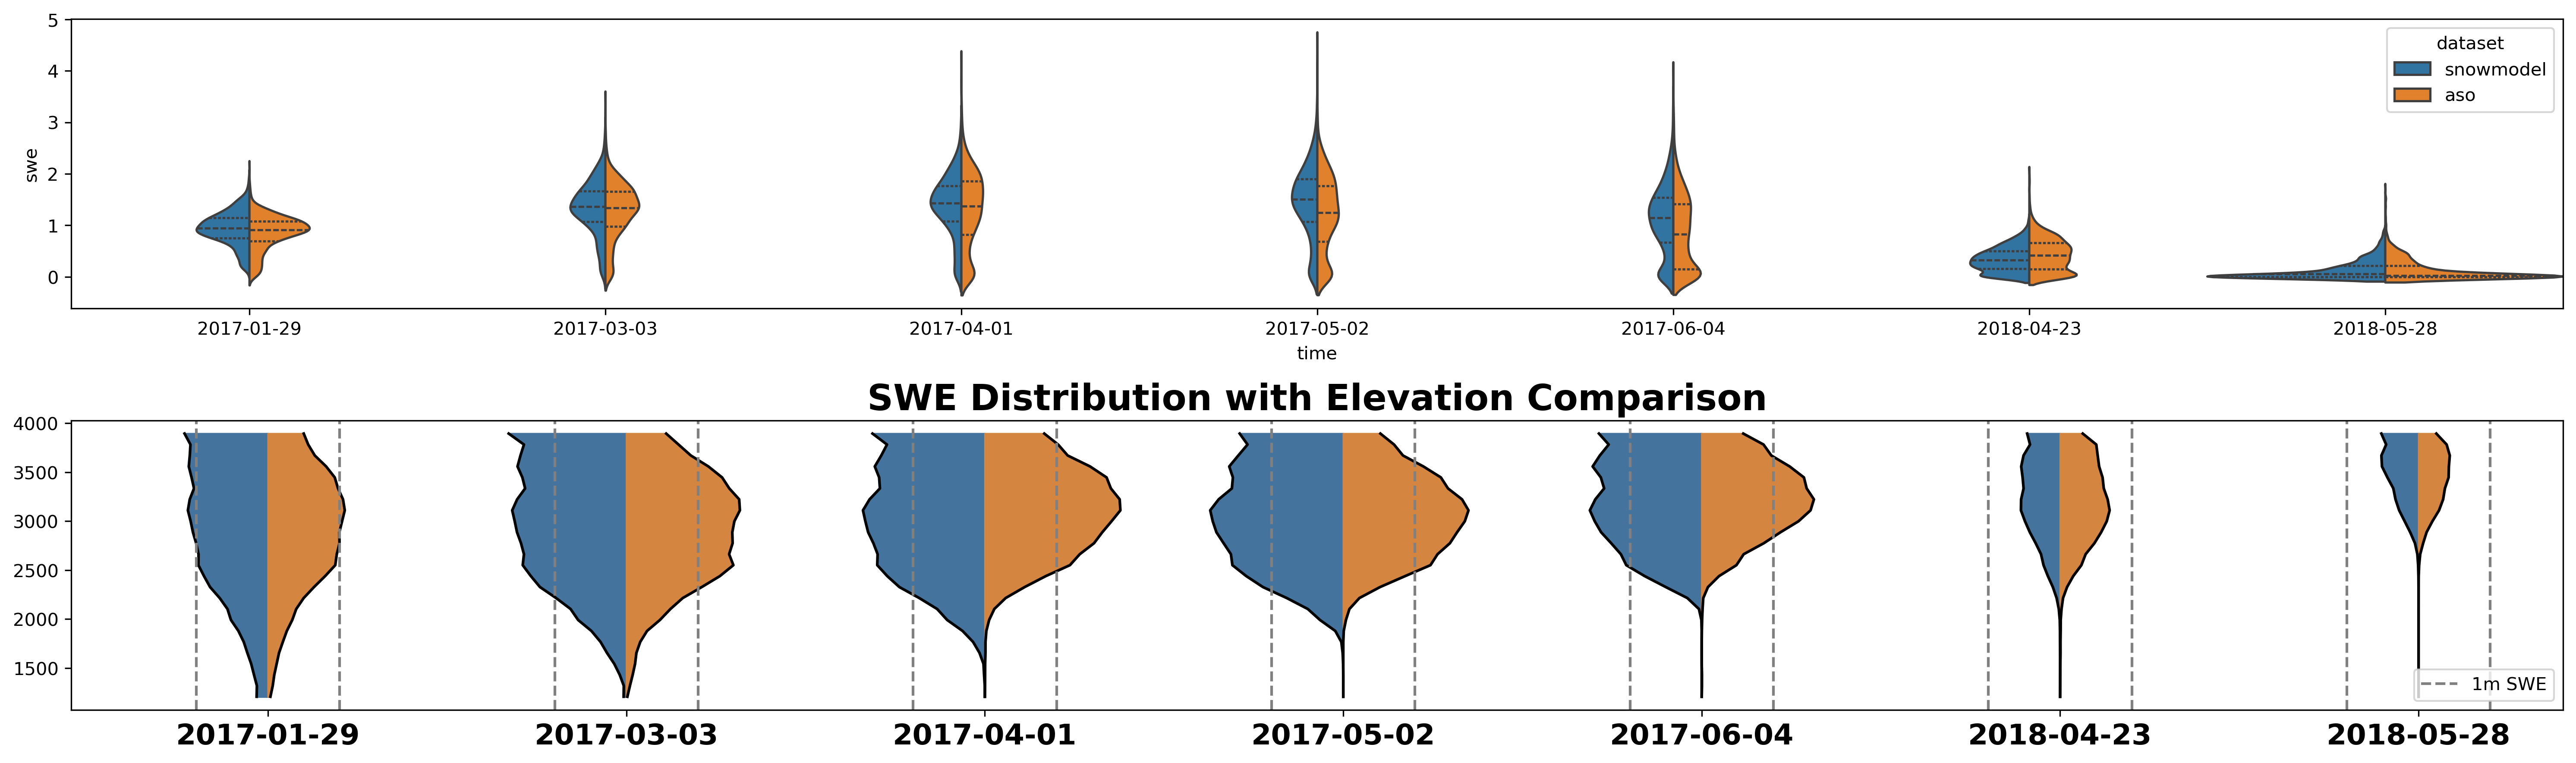

In [13]:
count = 0
fig,ax = plt.subplots(2,1,figsize = (20,6),dpi = 300)
sns.violinplot(ax=ax[0],data=violin_df, x="time", y="swe", hue="dataset", split=True, inner="quart",width = 1)
# ax[0].set_yticklabels([])
# ax[0].set_xticklabels([])
# ax[0].set_ylabel('')
# ax[0].set_xlabel('')
# ax[0].set_title('SWE Distribution Distribution Comparison',fontweight = 'bold',fontsize = 20)
for date in dsweDz_df.time.sort_values().unique():
    print(date)
    df_dswe_dz = dsweDz_df[dsweDz_df['time'] == date]
    df_dswe_dz['mean_swe_sm'] = df_dswe_dz['mean_swe_sm'] * -1
    
    ax[1].plot(df_dswe_dz.mean_swe_sm+count,df_dswe_dz.elev,color = 'black')
    ax[1].plot((df_dswe_dz.mean_swe_aso+count),df_dswe_dz.elev,color = 'black')
    
    ax[1].fill_betweenx(df_dswe_dz.elev, df_dswe_dz.mean_swe_sm+count, count, color='#44739D')
    ax[1].fill_betweenx(df_dswe_dz.elev, (df_dswe_dz.mean_swe_aso+count), count, color='#D48640')
    count += 5
ax[1].axvline(-1,linestyle = '--',color = 'gray')
ax[1].axvline(1,linestyle = '--',color = 'gray')

ax[1].axvline(4,linestyle = '--',color = 'gray')
ax[1].axvline(6,linestyle = '--',color = 'gray')

ax[1].axvline(9,linestyle = '--',color = 'gray')
ax[1].axvline(11,linestyle = '--',color = 'gray')

ax[1].axvline(14,linestyle = '--',color = 'gray')
ax[1].axvline(16,linestyle = '--',color = 'gray')

ax[1].axvline(19,linestyle = '--',color = 'gray')
ax[1].axvline(21,linestyle = '--',color = 'gray')

ax[1].axvline(24,linestyle = '--',color = 'gray')
ax[1].axvline(26,linestyle = '--',color = 'gray')

ax[1].axvline(29,linestyle = '--',color = 'gray')
ax[1].axvline(31,linestyle = '--',color = 'gray',label = '1m SWE')
ax[1].legend(loc = 'lower right')
plt.xticks([0,5,10,15,20,25,30],dsweDz_df.time.sort_values().dt.date.unique(),fontweight = 'bold',fontsize = 16)
# ax[1].set_yticklabels([])
ax[1].set_title('SWE Distribution with Elevation Comparison',fontweight = 'bold',fontsize = 20)
plt.tight_layout()
plt.savefig('distributed_comp.png',dpi = 300)

2017-01-29 00:00:00
2017-03-03 00:00:00
2017-04-01 00:00:00
2017-05-02 00:00:00
2017-06-04 00:00:00
2018-04-23 00:00:00
2018-05-28 00:00:00


/glade/derecho/scratch/rossamower/tmp/ipykernel_13707/3943093998.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dswe_dz['mean_swe_sm'] = df_dswe_dz['mean_swe_sm'] * -1


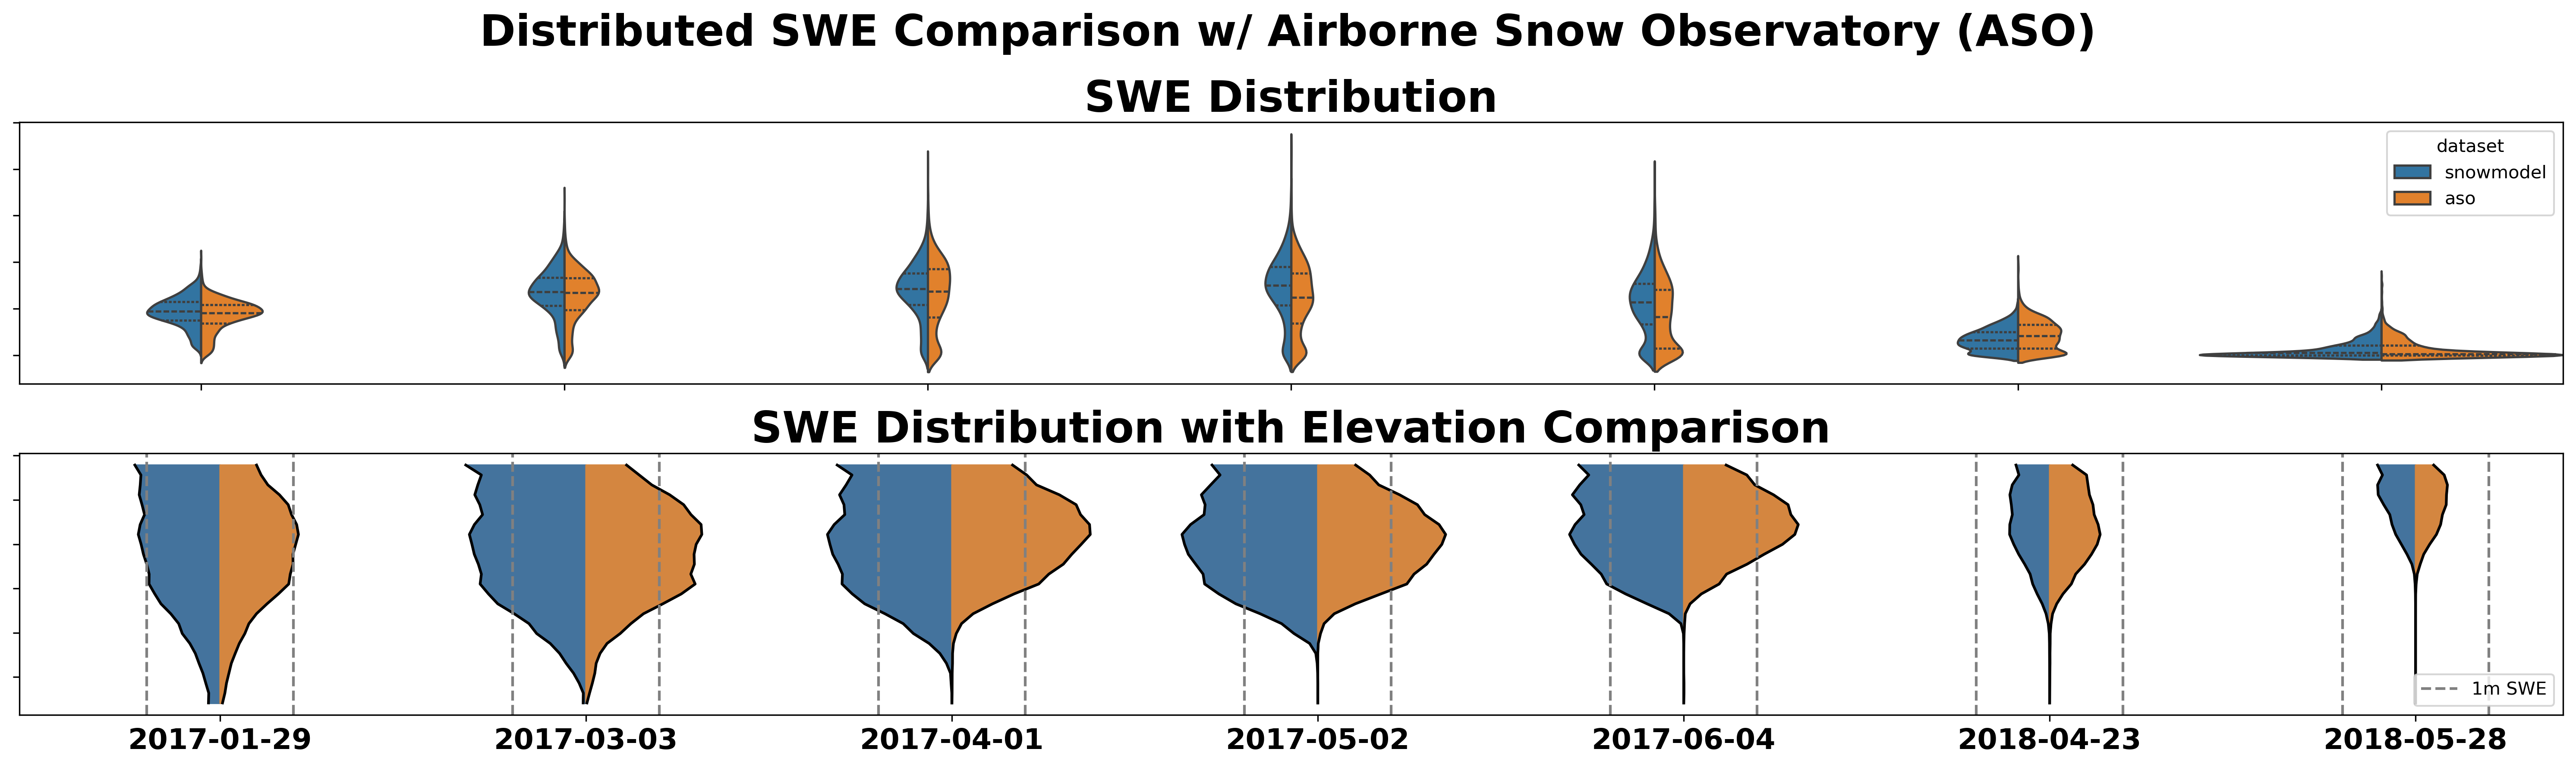

In [17]:
count = 0
fig,ax = plt.subplots(2,1,figsize = (20,6),dpi = 300)
sns.violinplot(ax=ax[0],data=violin_df, x="time", y="swe", hue="dataset", split=True, inner="quart",width = 1)
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_title('SWE Distribution',fontweight = 'bold',fontsize = 24)
for date in dsweDz_df.time.sort_values().unique():
    print(date)
    df_dswe_dz = dsweDz_df[dsweDz_df['time'] == date]
    df_dswe_dz['mean_swe_sm'] = df_dswe_dz['mean_swe_sm'] * -1
    
    ax[1].plot(df_dswe_dz.mean_swe_sm+count,df_dswe_dz.elev,color = 'black')
    ax[1].plot((df_dswe_dz.mean_swe_aso+count),df_dswe_dz.elev,color = 'black')
    
    ax[1].fill_betweenx(df_dswe_dz.elev, df_dswe_dz.mean_swe_sm+count, count, color='#44739D')
    ax[1].fill_betweenx(df_dswe_dz.elev, (df_dswe_dz.mean_swe_aso+count), count, color='#D48640')
    count += 5
ax[1].axvline(-1,linestyle = '--',color = 'gray')
ax[1].axvline(1,linestyle = '--',color = 'gray')

ax[1].axvline(4,linestyle = '--',color = 'gray')
ax[1].axvline(6,linestyle = '--',color = 'gray')

ax[1].axvline(9,linestyle = '--',color = 'gray')
ax[1].axvline(11,linestyle = '--',color = 'gray')

ax[1].axvline(14,linestyle = '--',color = 'gray')
ax[1].axvline(16,linestyle = '--',color = 'gray')

ax[1].axvline(19,linestyle = '--',color = 'gray')
ax[1].axvline(21,linestyle = '--',color = 'gray')

ax[1].axvline(24,linestyle = '--',color = 'gray')
ax[1].axvline(26,linestyle = '--',color = 'gray')

ax[1].axvline(29,linestyle = '--',color = 'gray')
ax[1].axvline(31,linestyle = '--',color = 'gray',label = '1m SWE')
ax[1].legend(loc = 'lower right')
plt.xticks([0,5,10,15,20,25,30],dsweDz_df.time.sort_values().dt.date.unique(),fontweight = 'bold',fontsize = 16)
ax[1].set_yticklabels([])
ax[1].set_title('SWE Distribution with Elevation Comparison',fontweight = 'bold',fontsize = 24)
plt.suptitle('Distributed SWE Comparison w/ Airborne Snow Observatory (ASO)',fontweight = 'bold',fontsize = 24)
plt.tight_layout()
plt.savefig('distributed_comp.png',dpi = 300)

In [87]:
df_dswe_dz

elev       time  mean_swe_sm  mean_swe_aso
0   1207.685181 2017-01-29     0.158361      0.033706
1   1319.595581 2017-01-29     0.154710      0.066137
2   1431.506104 2017-01-29     0.195169      0.087872
3   1543.416504 2017-01-29     0.234353      0.120986
4   1655.326904 2017-01-29     0.288031      0.154141
5   1767.237305 2017-01-29     0.338194      0.207398
6   1879.147705 2017-01-29     0.412770      0.262829
7   1991.058228 2017-01-29     0.516539      0.338857
8   2102.968750 2017-01-29     0.565276      0.393912
9   2214.878906 2017-01-29     0.673595      0.497969
10  2326.789551 2017-01-29     0.807576      0.641648
11  2438.699707 2017-01-29     0.892381      0.797024
12  2550.610352 2017-01-29     0.970338      0.938495
13  2662.520996 2017-01-29     0.968645      0.959486
14  2774.431152 2017-01-29     1.002199      0.997618
15  2886.341797 2017-01-29     1.046794      0.995751
16  2998.251953 2017-01-29     1.078596      1.033387
17  3110.162598 2017-01-29     1.117316      1.071216
18  3222.072754 2017-01-29     1.091543      1.046700
19  3333.983398 2017-01-29     1.031780      0.977059
20  3445.893799 2017-01-29     1.066162      0.931350
21  3557.804199 2017-01-29     1.104663      0.811579
22  3669.714844 2017-01-29     1.090679      0.653122
23  3781.625000 2017-01-29     1.081456      0.560972
24  3893.535645 2017-01-29     1.164073      0.498751

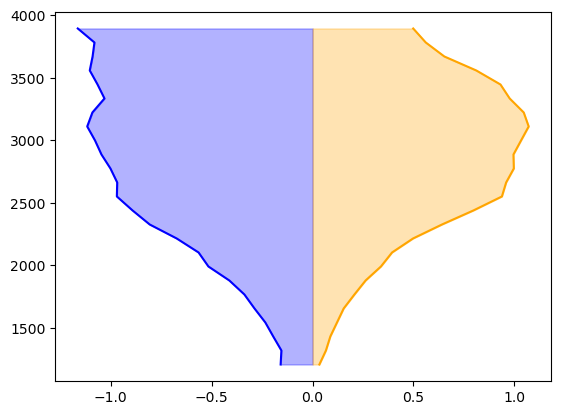

In [94]:
fig,ax = plt.subplots()
ax.plot(df_dswe_dz.mean_swe_sm*-1,df_dswe_dz.elev,color = 'blue')
ax.plot(df_dswe_dz.mean_swe_aso,df_dswe_dz.elev,color = 'orange')
plt.fill_betweenx(df_dswe_dz.elev, df_dswe_dz.mean_swe_sm*-1, 0, color='blue', alpha=0.3)
plt.fill_betweenx(df_dswe_dz.elev, df_dswe_dz.mean_swe_aso, 0, color='orange', alpha=0.3)

In [93]:
df_dswe_dz

elev       time  mean_swe_sm  mean_swe_aso
0   1207.685181 2018-05-28     0.158361      0.033706
1   1319.595581 2018-05-28     0.154710      0.066137
2   1431.506104 2018-05-28     0.195169      0.087872
3   1543.416504 2018-05-28     0.234353      0.120986
4   1655.326904 2018-05-28     0.288031      0.154141
5   1767.237305 2018-05-28     0.338194      0.207398
6   1879.147705 2018-05-28     0.412770      0.262829
7   1991.058228 2018-05-28     0.516539      0.338857
8   2102.968750 2018-05-28     0.565276      0.393912
9   2214.878906 2018-05-28     0.673595      0.497969
10  2326.789551 2018-05-28     0.807576      0.641648
11  2438.699707 2018-05-28     0.892381      0.797024
12  2550.610352 2018-05-28     0.970338      0.938495
13  2662.520996 2018-05-28     0.968645      0.959486
14  2774.431152 2018-05-28     1.002199      0.997618
15  2886.341797 2018-05-28     1.046794      0.995751
16  2998.251953 2018-05-28     1.078596      1.033387
17  3110.162598 2018-05-28     1.117316      1.071216
18  3222.072754 2018-05-28     1.091543      1.046700
19  3333.983398 2018-05-28     1.031780      0.977059
20  3445.893799 2018-05-28     1.066162      0.931350
21  3557.804199 2018-05-28     1.104663      0.811579
22  3669.714844 2018-05-28     1.090679      0.653122
23  3781.625000 2018-05-28     1.081456      0.560972
24  3893.535645 2018-05-28     1.164073      0.498751

In [ ]:
fig,ax = plt.subplots()
ax.plot(df_dswe_dz.mean_swe_sm*-1,df_dswe_dz.elev,color = 'blue')
ax.plot(df_dswe_dz.mean_swe_aso,df_dswe_dz.elev,color = 'orange')
plt.fill_betweenx(df_dswe_dz.elev, df_dswe_dz.mean_swe_sm*-1, 0, color='blue', alpha=0.3)
plt.fill_betweenx(df_dswe_dz.elev, df_dswe_dz.mean_swe_aso, 0, color='orange', alpha=0.3)

In [12]:
num_bins = 25
hgt_vals_sm = ds['hgt'].values
hgt_vals_sm = hgt_vals_sm[~np.isnan(hgt_vals_sm)]
count_sm,bins_sm = np.histogram(hgt_vals_sm,bins = num_bins)
labels_sm = np.arange(0,num_bins)


In [13]:
ds

<xarray.Dataset> Size: 4MB
Dimensions:    (time: 1, y: 494, x: 517)
Coordinates:
  * time       (time) datetime64[ns] 8B 2017-01-29
  * y          (y) float64 4kB 4.23e+06 4.229e+06 ... 4.18e+06 4.179e+06
  * x          (x) float64 4kB 2.54e+05 2.541e+05 ... 3.064e+05 3.065e+05
Data variables:
    aso        (time, y, x) float64 2MB nan nan nan nan nan ... nan nan nan nan
    snowmodel  (time, y, x) float32 1MB nan nan nan nan nan ... nan nan nan nan
    hgt        (y, x) float32 1MB nan nan nan nan nan ... nan nan nan nan nan

In [78]:
[str(ds.time.values[0])[0:10]]*2

['2017-01-29', '2017-01-29']

In [21]:
distributed_swe = ds
swe_var = 'snowmodel'
vals_sm_lst = []
elevs_sm_lst = []

for i in range(0,len(labels_sm)):
    print(i,end = ' ')
    ## bin based on snowmodel elevation ##
    try:
        val = float(distributed_swe.squeeze('time').groupby_bins('hgt',bins_sm,labels = labels_sm)[labels_sm[i]][swe_var].mean().values) ## snowmodel elevation bins
    except:
        val = np.nan
    elev = (bins_sm[i] + bins_sm[i+1]) / 2 ## snowmodel bins
            
    ## append snowmodel vals ##
    vals_sm_lst.append(val)
    elevs_sm_lst.append(elev)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [22]:
distributed_swe = ds
swe_var = 'aso'
vals_aso_lst = []
elevs_aso_lst = []

for i in range(0,len(labels_sm)):
    print(i,end = ' ')
    ## bin based on snowmodel elevation ##
    try:
        val = float(distributed_swe.squeeze('time').groupby_bins('hgt',bins_sm,labels = labels_sm)[labels_sm[i]][swe_var].mean().values) ## snowmodel elevation bins
    except:
        val = np.nan
    elev = (bins_sm[i] + bins_sm[i+1]) / 2 ## snowmodel bins
            
    ## append snowmodel vals ##
    vals_aso_lst.append(val)
    elevs_aso_lst.append(elev)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [63]:
df_dswe_dz

elev  mean_swe_sm  mean_swe_aso
0   1207.685181     0.158361      0.033706
1   1319.595581     0.154710      0.066137
2   1431.506104     0.195169      0.087872
3   1543.416504     0.234353      0.120986
4   1655.326904     0.288031      0.154141
5   1767.237305     0.338194      0.207398
6   1879.147705     0.412770      0.262829
7   1991.058228     0.516539      0.338857
8   2102.968750     0.565276      0.393912
9   2214.878906     0.673595      0.497969
10  2326.789551     0.807576      0.641648
11  2438.699707     0.892381      0.797024
12  2550.610352     0.970338      0.938495
13  2662.520996     0.968645      0.959486
14  2774.431152     1.002199      0.997618
15  2886.341797     1.046794      0.995751
16  2998.251953     1.078596      1.033387
17  3110.162598     1.117316      1.071216
18  3222.072754     1.091543      1.046700
19  3333.983398     1.031780      0.977059
20  3445.893799     1.066162      0.931350
21  3557.804199     1.104663      0.811579
22  3669.714844     1.090679      0.653122
23  3781.625000     1.081456      0.560972
24  3893.535645     1.164073      0.498751

In [28]:
df_dswe_dz = pd.DataFrame(data = {'elev':elevs_sm_lst,
                     'mean_swe_sm':vals_sm_lst,
                     'mean_swe_aso':vals_aso_lst}
            )

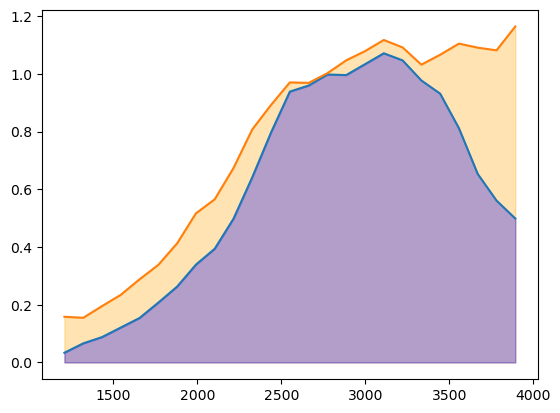

In [56]:
fig,ax = plt.subplots()
ax.plot(df_dswe_dz.elev,df_dswe_dz.mean_swe_sm)
ax.plot(df_dswe_dz.elev,df_dswe_dz.mean_swe_aso)

plt.fill_between(df_dswe_dz.elev, df_dswe_dz.mean_swe_sm, 0, color='orange', alpha=0.3)
plt.fill_between(df_dswe_dz.elev, df_dswe_dz.mean_swe_aso, 0, color='blue', alpha=0.3)

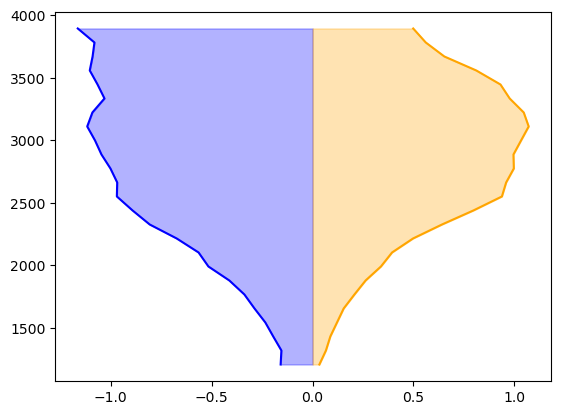

In [62]:
fig,ax = plt.subplots()
ax.plot(df_dswe_dz.mean_swe_sm*-1,df_dswe_dz.elev,color = 'blue')
ax.plot(df_dswe_dz.mean_swe_aso,df_dswe_dz.elev,color = 'orange')
plt.fill_betweenx(df_dswe_dz.elev, df_dswe_dz.mean_swe_sm*-1, 0, color='blue', alpha=0.3)
plt.fill_betweenx(df_dswe_dz.elev, df_dswe_dz.mean_swe_aso, 0, color='orange', alpha=0.3)

In [54]:
plt.fill_between?

Signature:
plt.fill_between(
    x: 'ArrayLike',
    y1: 'ArrayLike | float',
    y2: 'ArrayLike | float' = 0,
    where: 'Sequence[bool] | None' = None,
    interpolate: 'bool' = False,
    step: "Literal['pre', 'post', 'mid'] | None" = None,
    *,
    data=None,
    **kwargs,
) -> 'PolyCollection'
Docstring:
Fill the area between two horizontal curves.

The curves are defined by the points (*x*, *y1*) and (*x*,
*y2*).  This creates one or multiple polygons describing the filled
area.

You may exclude some horizontal sections from filling using *where*.

By default, the edges connect the given points directly.  Use *step*
if the filling should be a step function, i.e. constant in between
*x*.

Parameters
----------
x : array (length N)
    The x coordinates of the nodes defining the curves.

y1 : array (length N) or scalar
    The y coordinates of the nodes defining the first curve.

y2 : array (length N) or scalar, default: 0
    The y coordinates of the nodes defining the second cu

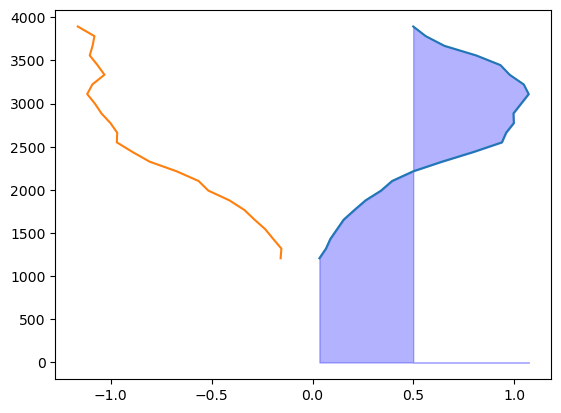

In [42]:
fig,ax = plt.subplots()
ax.plot(df_dswe_dz.mean_swe_aso,df_dswe_dz.elev)
ax.plot(df_dswe_dz.mean_swe_sm*-1,df_dswe_dz.elev)
plt.fill_between(df_dswe_dz.mean_swe_aso, df_dswe_dz.elev, 0, where=(df_dswe_dz.elev > 0), color='blue', alpha=0.3)


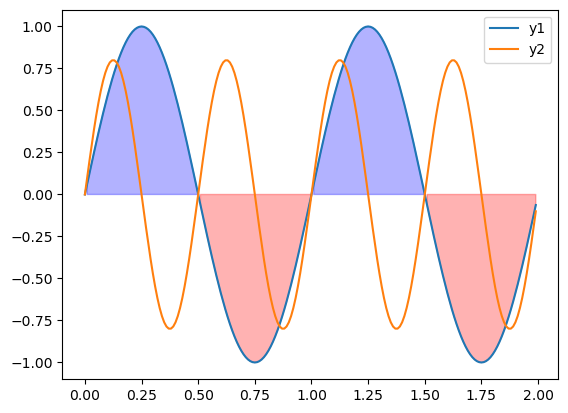

In [34]:
x = np.arange(0, 2, 0.01)
y1 = np.sin(2 * np.pi * x)
y2 = 0.8 * np.sin(4 * np.pi * x)

plt.plot(x, y1, label='y1')
plt.plot(x, y2, label='y2')

plt.fill_between(x, y1, 0, where=(y1 > 0), color='blue', alpha=0.3)
plt.fill_between(x, y1, 0, where=(y1 < 0), color='red', alpha=0.3)

plt.legend()
plt.show()

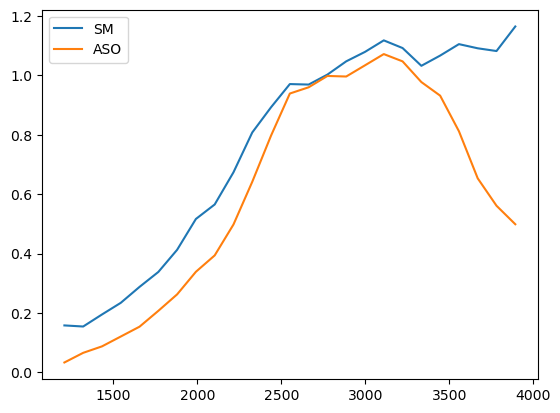

In [20]:
fig,ax = plt.subplots()
plt.plot(elevs_aso_lst,vals_lst,label = 'SM')
plt.plot(elevs_aso_lst,vals_aso_lst,label = 'ASO')
plt.legend()

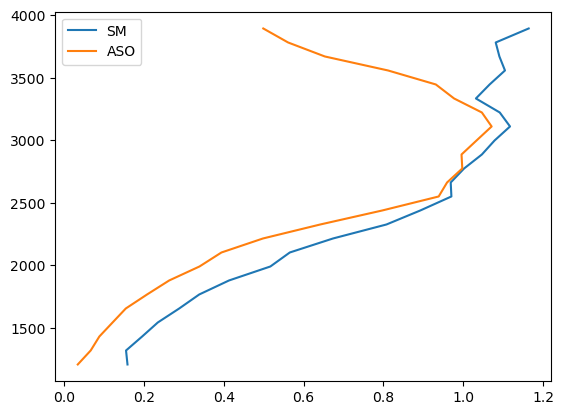

In [18]:
fig,ax = plt.subplots()
plt.plot(vals_lst,elevs_aso_lst,label = 'SM')
plt.plot(vals_aso_lst,elevs_aso_lst,label = 'ASO')
plt.legend()

In [113]:
import seaborn as sns

In [129]:
ds.coarsen?

Signature:
ds.coarsen(
    dim: 'Mapping[Any, int] | None' = None,
    boundary: 'CoarsenBoundaryOptions' = 'exact',
    side: 'SideOptions | Mapping[Any, SideOptions]' = 'left',
    coord_func: 'str | Callable | Mapping[Any, str | Callable]' = 'mean',
    **window_kwargs: 'int',
) -> 'DatasetCoarsen'
Docstring:
Coarsen object for Datasets.

Parameters
----------
dim : mapping of hashable to int, optional
    Mapping from the dimension name to the window size.
boundary : {"exact", "trim", "pad"}, default: "exact"
    If 'exact', a ValueError will be raised if dimension size is not a
    multiple of the window size. If 'trim', the excess entries are
    dropped. If 'pad', NA will be padded.
side : {"left", "right"} or mapping of str to {"left", "right"}, default: "left"
coord_func : str or mapping of hashable to str, default: "mean"
    function (name) that is applied to the coordinates,
    or a mapping from coordinate name to function (name).

Returns
-------
core.rolling.DatasetCoars

In [132]:
ds.coarsen({'x':10,'y':10},boundary = 'pad').mean()

<xarray.Dataset> Size: 32kB
Dimensions:    (time: 1, y: 50, x: 52)
Coordinates:
  * time       (time) datetime64[ns] 8B 2018-04-23
  * y          (y) float64 400B 4.229e+06 4.228e+06 ... 4.18e+06 4.18e+06
  * x          (x) float64 416B 2.545e+05 2.555e+05 ... 3.053e+05 3.062e+05
Data variables:
    aso        (time, y, x) float32 10kB nan nan nan nan nan ... nan nan nan nan
    snowmodel  (time, y, x) float32 10kB nan nan nan nan nan ... nan nan nan nan
    hgt        (y, x) float32 10kB nan nan nan nan nan ... nan nan nan nan nan

In [151]:
df_aso = ds.aso.coarsen({'x':10,'y':10},boundary = 'pad').mean().to_dataframe().reset_index()
df_sm = ds.snowmodel.coarsen({'x':10,'y':10},boundary = 'pad').mean().to_dataframe().reset_index()
df_sm.rename(columns = {'snowmodel':'swe'},inplace = True)
df_aso.rename(columns = {'aso':'swe'},inplace = True)
df_sm['dataset'] = 'snowmodel'
df_aso['dataset'] = 'aso'
df_swe = pd.concat([df_aso,df_sm]).reset_index()
df_swe

index       time             y              x  swe    dataset
0         0 2018-04-23  4.229082e+06  254501.710173  NaN        aso
1         1 2018-04-23  4.229082e+06  255518.186661  NaN        aso
2         2 2018-04-23  4.229082e+06  256534.663149  NaN        aso
3         3 2018-04-23  4.229082e+06  257551.139637  NaN        aso
4         4 2018-04-23  4.229082e+06  258567.616125  NaN        aso
...     ...        ...           ...            ...  ...        ...
5195   2595 2018-04-23  4.179580e+06  302276.105102  NaN  snowmodel
5196   2596 2018-04-23  4.179580e+06  303292.581590  NaN  snowmodel
5197   2597 2018-04-23  4.179580e+06  304309.058078  NaN  snowmodel
5198   2598 2018-04-23  4.179580e+06  305325.534566  NaN  snowmodel
5199   2599 2018-04-23  4.179580e+06  306189.539580  NaN  snowmodel

[5200 rows x 6 columns]

<Axes: xlabel='aso'>

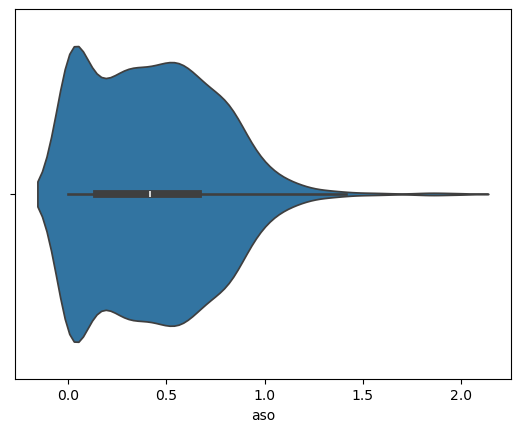

In [138]:
sns.violinplot(data=df_aso, x="aso")

<Axes: xlabel='time', ylabel='swe'>

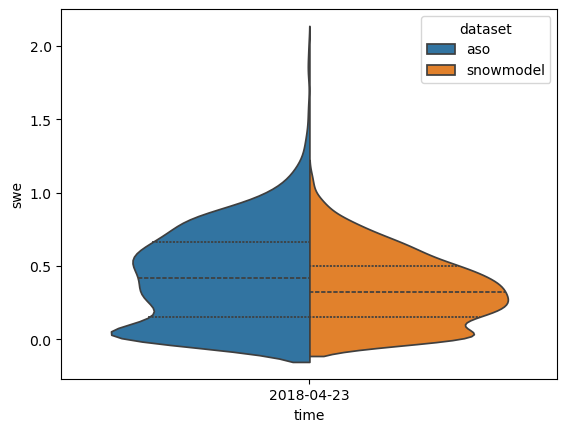

In [154]:
sns.violinplot(data=df_swe, x="time", y="swe", hue="dataset", split=True, inner="quart")

<Axes: xlabel='swe', ylabel='dataset'>

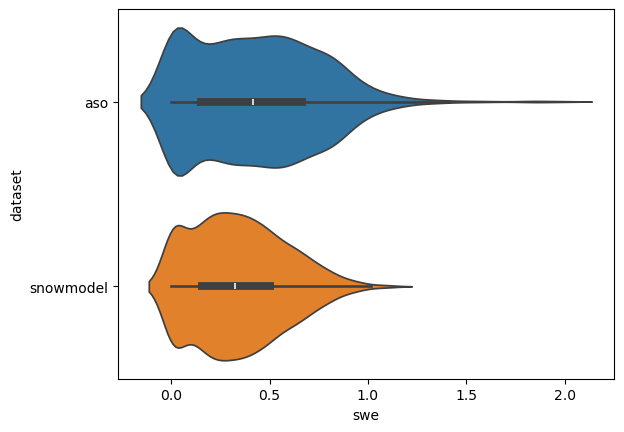

In [153]:
sns.violinplot(data=df_swe, x="swe", y="dataset",hue = 'dataset')

<Axes: xlabel='age'>

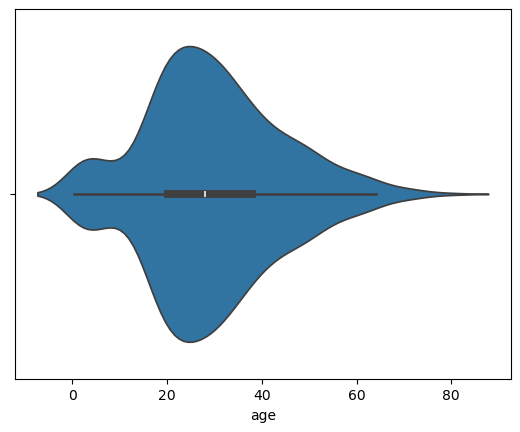

In [146]:
df = sns.load_dataset("titanic")
sns.violinplot(x=df["age"])

In [147]:
df

survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0           0       3    male  22.0      1      0   7.2500        S   Third   
1           1       1  female  38.0      1      0  71.2833        C   First   
2           1       3  female  26.0      0      0   7.9250        S   Third   
3           1       1  female  35.0      1      0  53.1000        S   First   
4           0       3    male  35.0      0      0   8.0500        S   Third   
..        ...     ...     ...   ...    ...    ...      ...      ...     ...   
886         0       2    male  27.0      0      0  13.0000        S  Second   
887         1       1  female  19.0      0      0  30.0000        S   First   
888         0       3  female   NaN      1      2  23.4500        S   Third   
889         1       1    male  26.0      0      0  30.0000        C   First   
890         0       3    male  32.0      0      0   7.7500        Q   Third   

       who  adult_male deck  embark_town alive  alone  
0      man        True  NaN  Southampton    no  False  
1    woman       False    C    Cherbourg   yes  False  
2    woman       False  NaN  Southampton   yes   True  
3    woman       False    C  Southampton   yes  False  
4      man        True  NaN  Southampton    no   True  
..     ...         ...  ...          ...   ...    ...  
886    man        True  NaN  Southampton    no   True  
887  woman       False    B  Southampton   yes   True  
888  woman       False  NaN  Southampton    no  False  
889    man        True    C    Cherbourg   yes   True  
890    man        True  NaN   Queenstown    no   True  

[891 rows x 15 columns]

<Axes: xlabel='age', ylabel='class'>

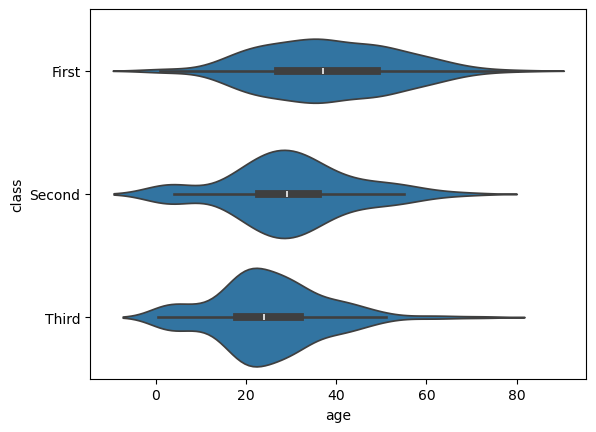

In [148]:
sns.violinplot(data=df, x="age", y="class")